## Transfer Learning on Cats-Dogs Classification - Fine Tune

#### Finetune MobileNet-V2 top layers and classification layers to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### HPC and Data Science Summer Institute
Mai H. Nguyen, UC San Diego

-----

### Setup

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

2023-08-07 19:13:57.834490: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print (tf.__version__)
!python --version

2.9.1
Python 3.8.10


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Mon Aug  7 19:14:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   42C    P0    55W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Set random generator seed
seed = 1234

# Set Python seed, NumPy seed, and TensorFlow seed
tf.keras.utils.set_random_seed(seed)

# Set numpy random generator
# np.random.seed(seed)

# Set python built-in random generator
# random.seed(seed)

# Set tf global random seed
# tf.random.set_seed(seed)

# Disable hash randomization by specifying the value 0.
# os.environ['PYTHONHASHSEED'] = '0'

# Potential randomness from CUDNN
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
import os 

from os.path import expanduser
HOME = expanduser("~")
data_path = HOME + '/data/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/home/train107/data/catsVsDogs
Train path:/home/train107/data/catsVsDogs/train
Validation path:/home/train107/data/catsVsDogs/val
Test path:/home/train107/data/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224, 224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data setup
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='binary', 
                                                    shuffle = True,
                                                    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size=IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              class_mode='binary',
                                                              shuffle = False, 
                                                              seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle = False,
                                                  seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load model from feature extraction
Load model saved from feature extraction.  Weights in last blocks and top model will be adjusted.  All other weights are frozen.

In [10]:
model = tf.keras.models.load_model('models/features_model')

2023-08-07 19:14:01.134442: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 19:14:01.596578: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-08-07 19:14:01.596702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [35]:
# Uncomment to list layers in model
# print("Number of layers in the base model: ", len(model.layers[1].layers))
# list(enumerate(model.layers[1].layers))

In [12]:
## Freeze all weights of model up to Block 14
model.trainable = True
fine_tune_start = 116
for layer in model.layers[1].layers[:fine_tune_start]:
    layer.trainable = False
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,682,625
Non-train

### Fine tune model

In [13]:
EPOCHS = 20

# Compile model with very slow learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

# Perform early stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min'),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode = 'min', 
                             save_best_only = True, save_weights_only=True)]

In [14]:
%%time

train_history = model.fit(train_generator,epochs=EPOCHS, 
                          validation_data=validation_generator, 
                          callbacks=callbacks)

Epoch 1/20


2023-08-07 19:14:09.776083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


125/125 [==============================] - 21s 136ms/step - loss: 0.2689 - accuracy: 0.8875 - val_loss: 0.0908 - val_accuracy: 0.9675
Epoch 2/20
125/125 [==============================] - 17s 132ms/step - loss: 0.1366 - accuracy: 0.9535 - val_loss: 0.0750 - val_accuracy: 0.9675
Epoch 3/20
125/125 [==============================] - 16s 132ms/step - loss: 0.1072 - accuracy: 0.9615 - val_loss: 0.0598 - val_accuracy: 0.9800
Epoch 4/20
125/125 [==============================] - 16s 131ms/step - loss: 0.1090 - accuracy: 0.9555 - val_loss: 0.0470 - val_accuracy: 0.9825
Epoch 5/20
125/125 [==============================] - 16s 131ms/step - loss: 0.0812 - accuracy: 0.9750 - val_loss: 0.0452 - val_accuracy: 0.9850
Epoch 6/20
125/125 [==============================] - 17s 132ms/step - loss: 0.0713 - accuracy: 0.9785 - val_loss: 0.0408 - val_accuracy: 0.9850
Epoch 7/20
125/125 [==============================] - 17s 133ms/step - loss: 0.0649 - accuracy: 0.9765 - val_loss: 0.0401 - val_accuracy: 0.9

In [15]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

In [16]:
# Save weights from finetuning
model.save("models/finetune_model")

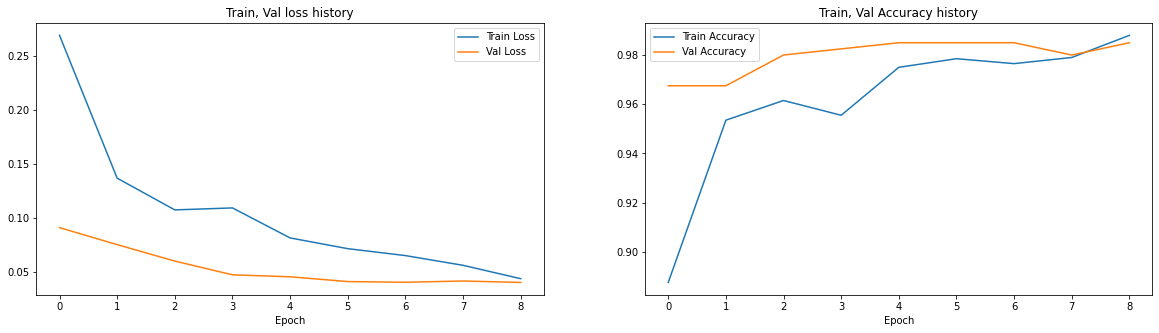

In [17]:
# Plot train and validation loss
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

# Plot train and validation accuracy
axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [18]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 16s 124ms/step - loss: 0.0126 - accuracy: 0.9980
Train data accuracy: 0.9980000257492065
25/25 [==============================] - 1s 22ms/step - loss: 0.0353 - accuracy: 0.9875
Test data accuracy: 0.987500011920929


In [19]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

25/25 [==============================] - 1s 23ms/step


In [20]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9851    0.9900    0.9875       200
        dogs     0.9899    0.9850    0.9875       200

    accuracy                         0.9875       400
   macro avg     0.9875    0.9875    0.9875       400
weighted avg     0.9875    0.9875    0.9875       400



### Perform inference on test images

In [21]:
def image_loader(img_file):
    """load individual images"""
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    # img = img_to_array(img) / 255
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

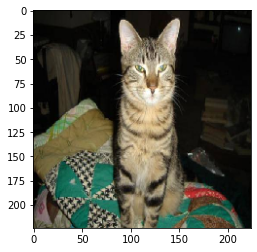

1/1 [==============================] - 1s 568ms/step
[[0.0007]]


In [22]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

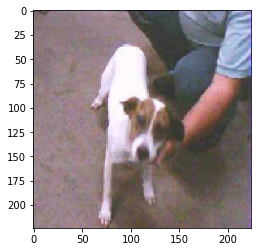

1/1 [==============================] - 0s 18ms/step
[[0.99988]]


In [23]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

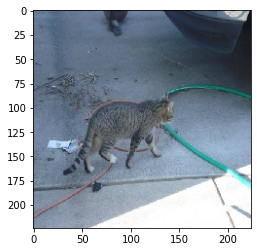

1/1 [==============================] - 0s 18ms/step
[[0.30385]]


In [24]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

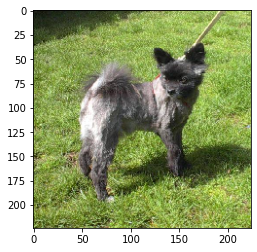

1/1 [==============================] - 0s 18ms/step
[[0.6511]]


In [25]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

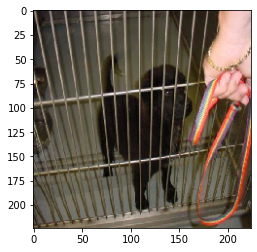

1/1 [==============================] - 0s 18ms/step
[[0.21289]]


In [26]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

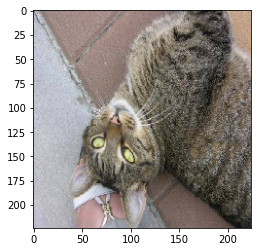

1/1 [==============================] - 0s 18ms/step
[[0.05024]]


In [27]:
test_image = data_path + '/test/cats/cat.1338.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

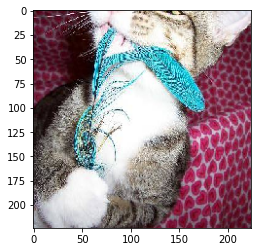

1/1 [==============================] - 0s 18ms/step
[[0.10843652]]


In [28]:
test_image = data_path + '/test/cats/cat.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(img_y_pred)

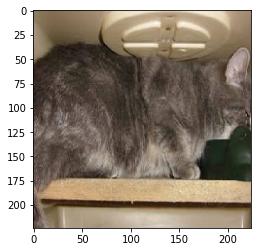

1/1 [==============================] - 0s 18ms/step
[[6.e-05]]


In [29]:
test_image = data_path + '/test/cats/cat.1180.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

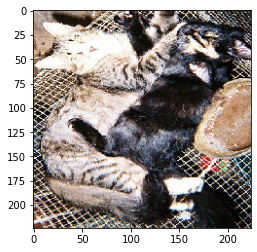

1/1 [==============================] - 0s 18ms/step
[[0.72962]]


In [30]:
test_image = data_path + '/test/cats/cat.1048.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

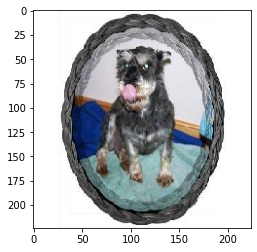

1/1 [==============================] - 0s 18ms/step
[[0.9976]]


In [31]:
test_image = data_path + '/test/dogs/dog.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))